# DSCI 552 Homework 6

Name: Ziyue Chen

Github Username: zic115

USC ID: 8823457220

In [1]:
# Import packages
import pandas as pd
import numpy as np
import math

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score, accuracy_score, mean_squared_error
from sklearn.model_selection import GridSearchCV, StratifiedKFold, cross_val_score
from xgboost import XGBClassifier
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE

# 1. Tree-Based Methods

## 1. (b) Data Preparation

In [2]:
# Import train and test data
train = pd.read_csv('../data/aps_failure_training_set.csv', skiprows = 20)
test = pd.read_csv('../data/aps_failure_test_set.csv', skiprows = 20)

In [3]:
# Preprocess the data
combined = pd.concat([train, test]).reset_index(drop = True)
combined = combined.replace('na', np.nan).replace('neg', 0).replace('pos', 1)
combined.iloc[:, 1:] = combined.iloc[:, 1:].astype(float)
combined

,class,aa_000,ab_000,ac_000,ad_000,ae_000,af_000,ag_000,ag_001,ag_002,...,ee_002,ee_003,ee_004,ee_005,ee_006,ee_007,ee_008,ee_009,ef_000,eg_000
0,0,76698.0,NaN,2.130706e+09,280.0,0.0,0.0,0.0,0.0,0.0,...,1240520.0,493384.0,721044.0,469792.0,339156.0,157956.0,73224.0,0.0,0.0,0.0
1,0,33058.0,NaN,0.000000e+00,NaN,0.0,0.0,0.0,0.0,0.0,...,421400.0,178064.0,293306.0,245416.0,133654.0,81140.0,97576.0,1500.0,0.0,0.0
2,0,41040.0,NaN,2.280000e+02,100.0,0.0,0.0,0.0,0.0,0.0,...,277378.0,159812.0,423992.0,409564.0,320746.0,158022.0,95128.0,514.0,0.0,0.0
3,0,12.0,0.0,7.000000e+01,66.0,0.0,10.0,0.0,0.0,0.0,...,240.0,46.0,58.0,44.0,10.0,0.0,0.0,0.0,4.0,32.0
4,0,60874.0,NaN,1.368000e+03,458.0,0.0,0.0,0.0,0.0,0.0,...,622012.0,229790.0,405298.0,347188.0,286954.0,311560.0,433954.0,1218.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75995,0,81852.0,NaN,2.130706e+09,892.0,0.0,0.0,0.0,0.0,0.0,...,632658.0,273242.0,510354.0,373918.0,349840.0,317840.0,960024.0,25566.0,0.0,0.0
75996,0,18.0,0.0,5.200000e+01,46.0,8.0,26.0,0.0,0.0,0.0,...,266.0,44.0,46.0,14.0,2.0,0.0,0.0,0.0,0.0,0.0
75997,0,79636.0,NaN,1.670000e+03,1518.0,0.0,0.0,0.0,0.0,0.0,...,806832.0,449962.0,778826.0,581558.0,375498.0,222866.0,358934.0,19548.0,0.0,0.0
75998,0,110.0,NaN,3.600000e+01,32.0,0.0,0.0,0.0,0.0,0.0,...,588.0,210.0,180.0,544.0,1004.0,1338.0,74.0,0.0,0.0,0.0


### 1. (b) i. Use a data imputation technique to deal with the missing values

Some data imputation techniques:

1) Use a constant value that has meaning within the domain

2) Use a value from another ramdomly selected observation

3) Use common statistics such as mean, median, or mode

4) Use a predictive model such as KNN to predict the value for the missing data point

In [4]:
# Use the mean of a feature to replace its missing values
features = list(combined.columns)[1:]
for feature in features:
    mean = combined[feature].mean()
    combined[feature] = combined[feature].replace(np.nan, mean)

combined

,class,aa_000,ab_000,ac_000,ad_000,ae_000,af_000,ag_000,ag_001,ag_002,...,ee_002,ee_003,ee_004,ee_005,ee_006,ee_007,ee_008,ee_009,ef_000,eg_000
0,0,76698.0,0.72556,2.130706e+09,280.000000,0.0,0.0,0.0,0.0,0.0,...,1240520.0,493384.0,721044.0,469792.0,339156.0,157956.0,73224.0,0.0,0.0,0.0
1,0,33058.0,0.72556,0.000000e+00,150629.962105,0.0,0.0,0.0,0.0,0.0,...,421400.0,178064.0,293306.0,245416.0,133654.0,81140.0,97576.0,1500.0,0.0,0.0
2,0,41040.0,0.72556,2.280000e+02,100.000000,0.0,0.0,0.0,0.0,0.0,...,277378.0,159812.0,423992.0,409564.0,320746.0,158022.0,95128.0,514.0,0.0,0.0
3,0,12.0,0.00000,7.000000e+01,66.000000,0.0,10.0,0.0,0.0,0.0,...,240.0,46.0,58.0,44.0,10.0,0.0,0.0,0.0,4.0,32.0
4,0,60874.0,0.72556,1.368000e+03,458.000000,0.0,0.0,0.0,0.0,0.0,...,622012.0,229790.0,405298.0,347188.0,286954.0,311560.0,433954.0,1218.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75995,0,81852.0,0.72556,2.130706e+09,892.000000,0.0,0.0,0.0,0.0,0.0,...,632658.0,273242.0,510354.0,373918.0,349840.0,317840.0,960024.0,25566.0,0.0,0.0
75996,0,18.0,0.00000,5.200000e+01,46.000000,8.0,26.0,0.0,0.0,0.0,...,266.0,44.0,46.0,14.0,2.0,0.0,0.0,0.0,0.0,0.0
75997,0,79636.0,0.72556,1.670000e+03,1518.000000,0.0,0.0,0.0,0.0,0.0,...,806832.0,449962.0,778826.0,581558.0,375498.0,222866.0,358934.0,19548.0,0.0,0.0
75998,0,110.0,0.72556,3.600000e+01,32.000000,0.0,0.0,0.0,0.0,0.0,...,588.0,210.0,180.0,544.0,1004.0,1338.0,74.0,0.0,0.0,0.0


### 1. (b) ii. Calculate the Coefficient of Variation CV for each feature

In [5]:
# Define a function to calculate CV
def calculateCV(column):
    std = column.std()
    mean = column.mean()
    CV = std / mean
    return CV

In [6]:
# Calculate CV for each feature
CV_values = {}
for feature in features:
    CV = calculateCV(combined[feature])
    CV_values[feature] = CV

CV_values

{'aa_000': 4.328607835435785,
 'ab_000': 2.178272593944041,
 'ac_000': 2.1676533085378886,
 'ad_000': 206.72149958176453,
 'ae_000': 22.293670429503308,
 'af_000': 18.209015502890768,
 'ag_000': 91.46065359583645,
 'ag_001': 42.08434252956986,
 'ag_002': 17.625908567425444,
 'ag_003': 8.753299520356666,
 'ag_004': 5.475116255434917,
 'ag_005': 2.9642299310403146,
 'ag_006': 2.3525878821684465,
 'ag_007': 2.8124979751566856,
 'ag_008': 6.274980079892739,
 'ag_009': 32.16705734053676,
 'ah_000': 2.3155400947419187,
 'ai_000': 18.506308128781928,
 'aj_000': 43.14447956358556,
 'ak_000': 78.62298773590766,
 'al_000': 9.11199122164582,
 'am_0': 9.067195453929418,
 'an_000': 2.2542266522583447,
 'ao_000': 2.2761144767667703,
 'ap_000': 3.0858848873966314,
 'aq_000': 2.853471317417596,
 'ar_000': 10.569202321811572,
 'as_000': 113.88275538316807,
 'at_000': 23.18705992823811,
 'au_000': 86.0856375114368,
 'av_000': 5.7304853575294405,
 'ax_000': 3.8590349934226182,
 'ay_000': 40.9025187557738

### 1. (b) iii. Plot a correlation matrix for the features

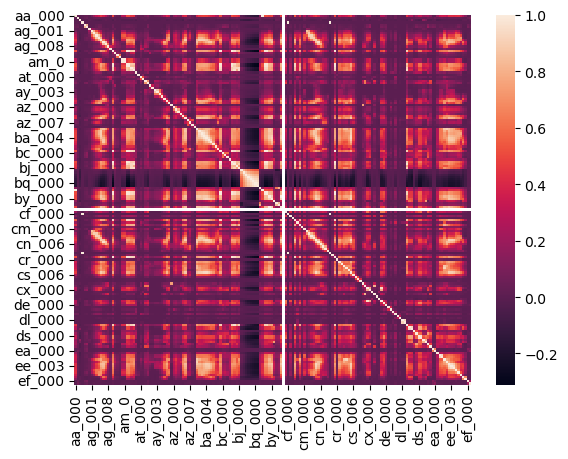

In [7]:
# Correlation matrix
corr = combined[features].corr()
sns.heatmap(corr)
plt.show()

### 1. (b) iv. Pick ⌊√170⌋ features with highest CV and make scatter plots and box plots for them

In [8]:
# Pick features
sorted_CV_values = sorted(CV_values.items(), key = lambda x: x[1], reverse = True)
n = math.floor(math.sqrt(170))
selected = sorted_CV_values[:n]
selected

[('cf_000', 207.2702736886315),
 ('co_000', 206.87612939952814),
 ('ad_000', 206.72149958176453),
 ('cs_009', 192.52261084543085),
 ('dj_000', 122.12815277529702),
 ('as_000', 113.88275538316807),
 ('dh_000', 112.65245027418743),
 ('df_000', 111.36966565765684),
 ('ag_000', 91.46065359583645),
 ('au_000', 86.0856375114368),
 ('ak_000', 78.62298773590766),
 ('az_009', 77.99955638588112),
 ('ay_009', 77.46110130112072)]

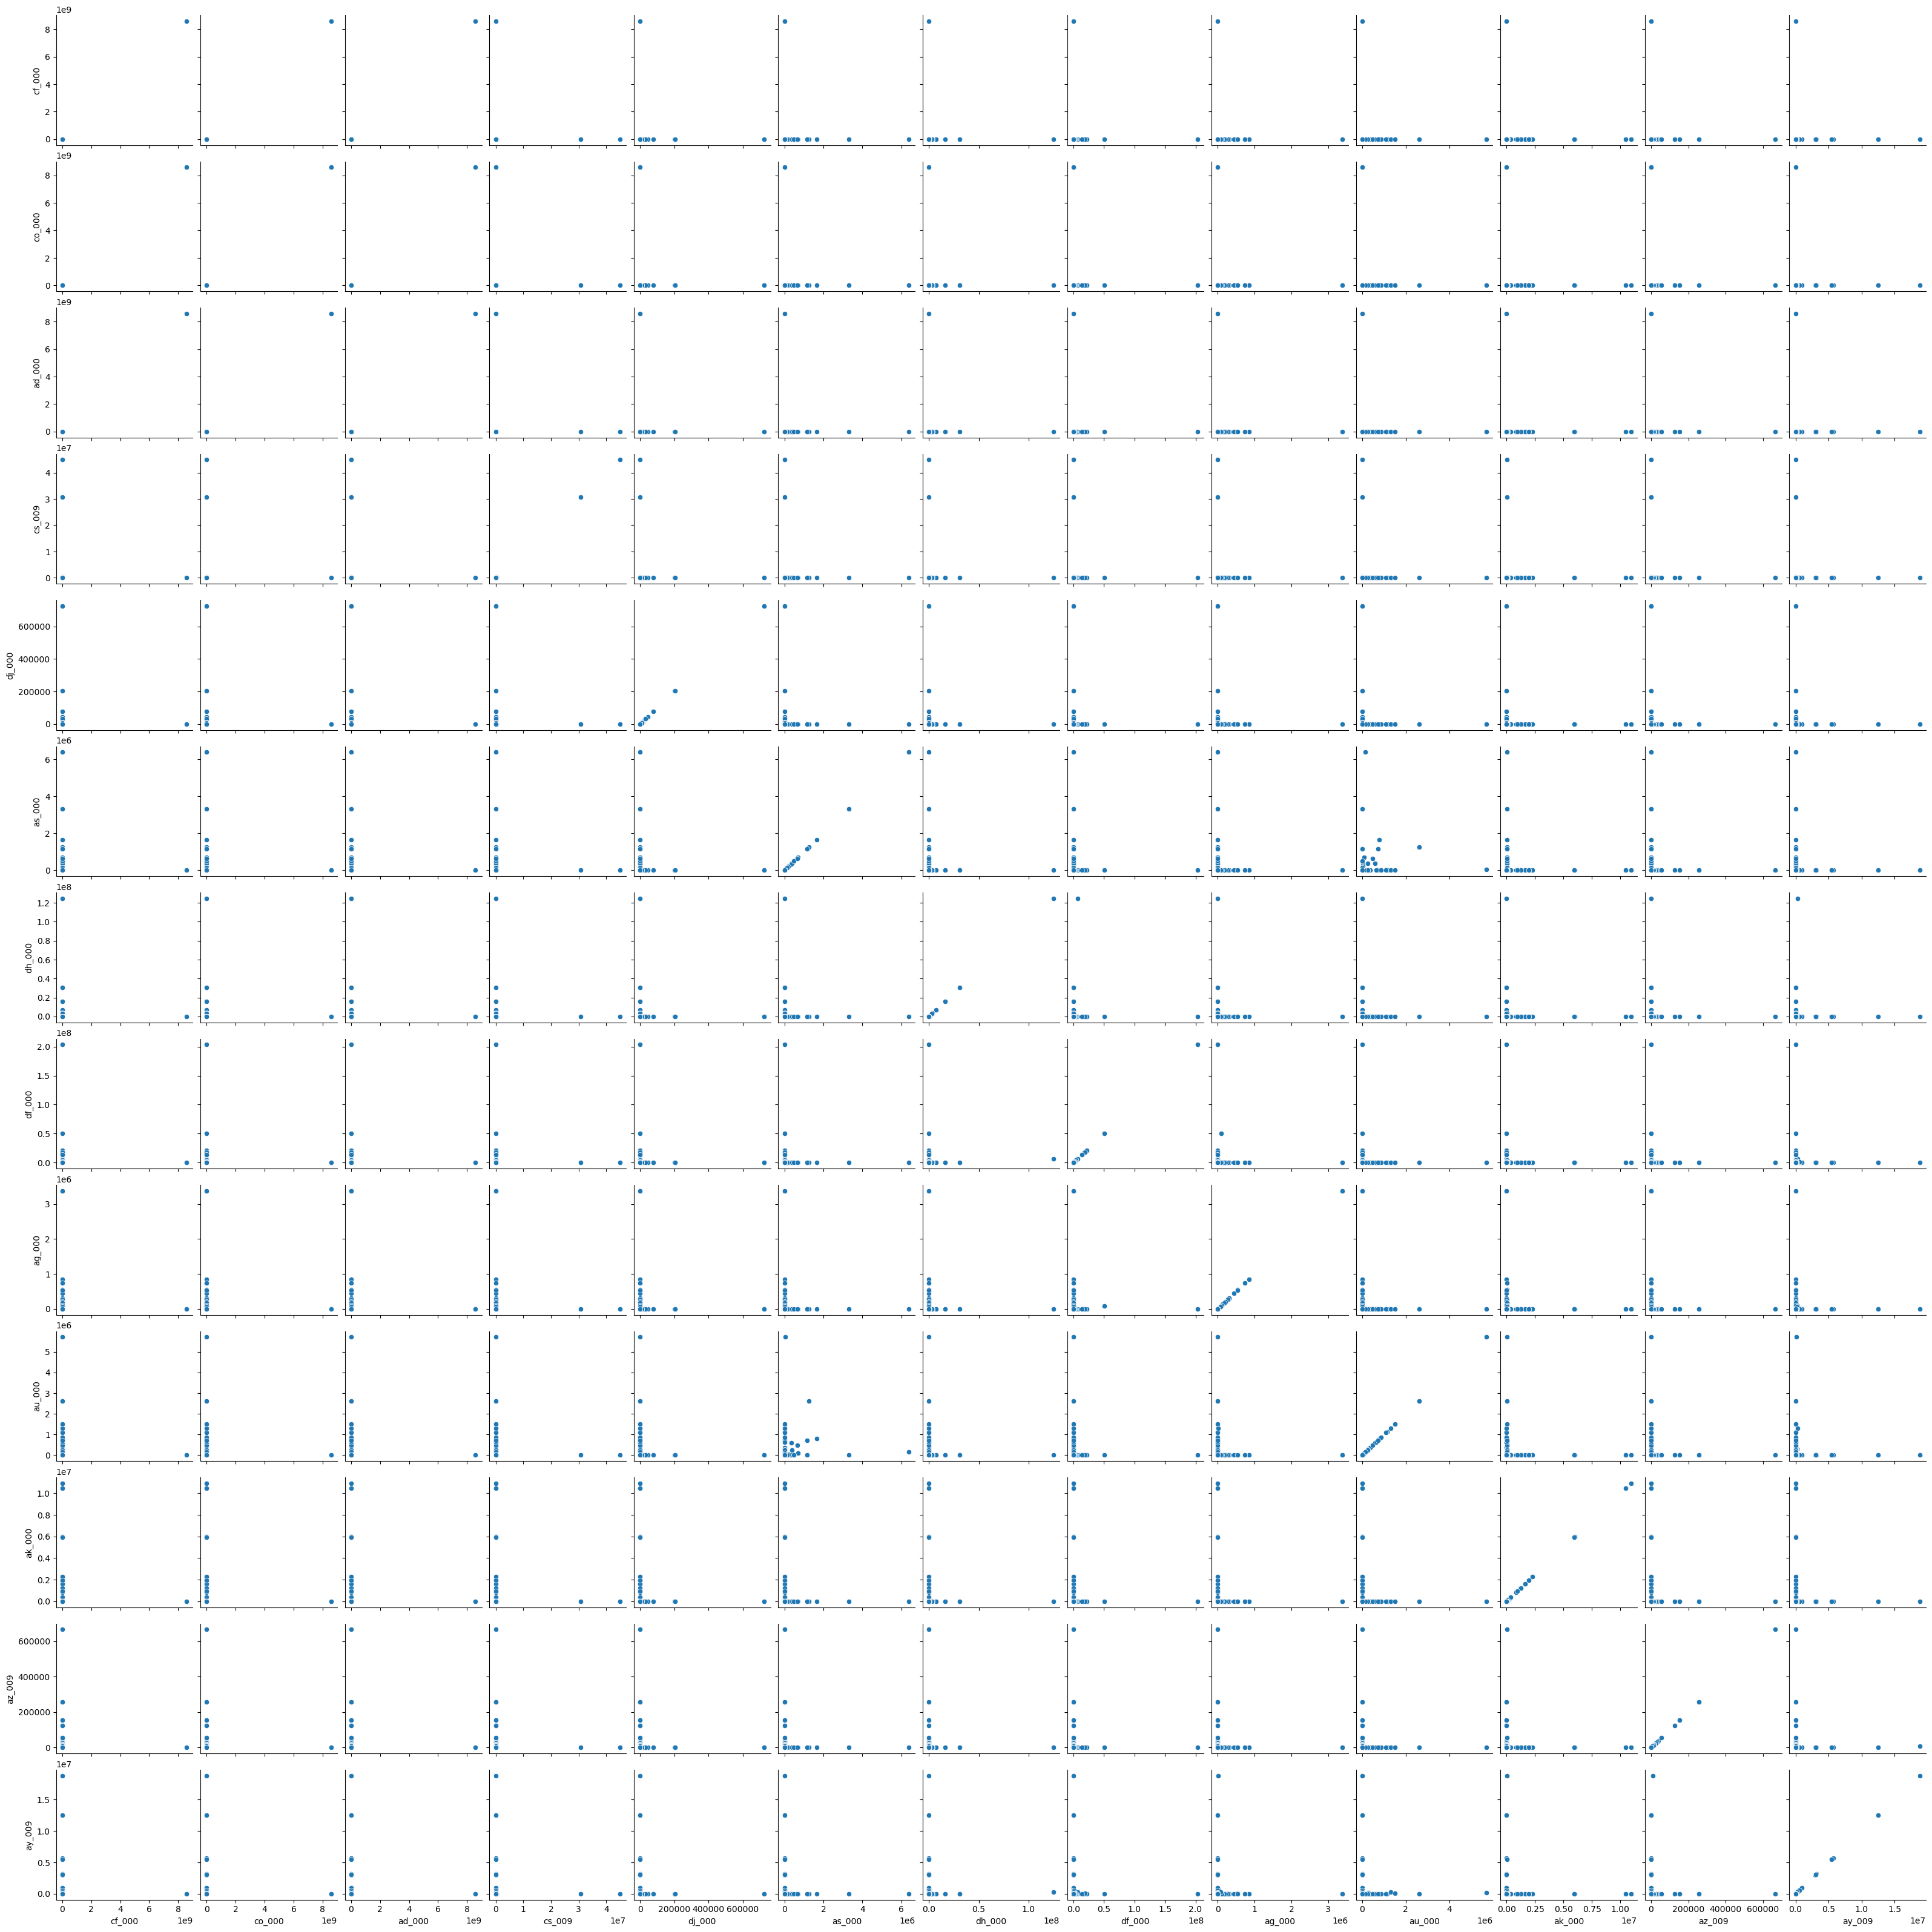

In [9]:
# Pairplot
selected_features = [selected[i][0] for i in range(len(selected))]
sns.pairplot(combined[selected_features], diag_kind = None)
plt.show()

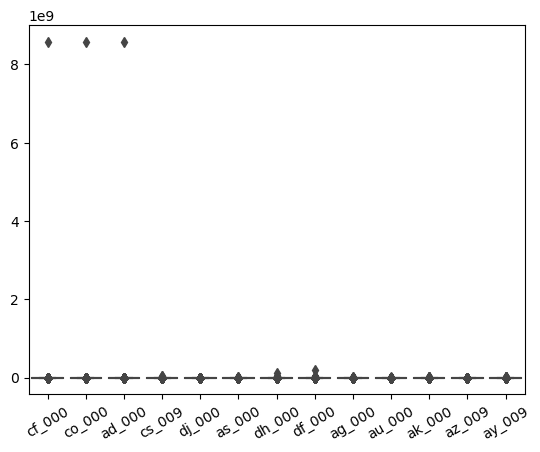

In [10]:
# Boxplot
sns.boxplot(data = combined[selected_features])
plt.xticks(rotation = 30)
plt.show()

Just by the pairplot, the significance of the selected features cannot be concluded, but we can observe correlation between some selected features such as  and  that have a strong linear relationship.

### 1. (b) v. Determine the number of positive and negative data

In [11]:
# Extractn positive and negative data
positive = len(combined[combined['class'] == 1])
negative = len(combined[combined['class'] == 0])
print('positive:', positive)
print('negative:', negative)

positive: 1375
negative: 74625


In [12]:
# Calculate the ratio
pos_percent = positive/negative * 100
print('percentage of positive:', pos_percent)

percentage of positive: 1.8425460636515913


This data set is imbalanced because the positive data is only 1.8% of the entire data. There is a lack of positive observations.

## 1. (c) Train a random forest to classify the data set without compensating for class imbalance

In [13]:
# Re-split training and test data
train = combined.iloc[:60000, :]
test = combined.iloc[60000:, :].reset_index(drop = True)

In [14]:
# Generate X and y
X_train = train.iloc[:, 1:]
y_train = train['class']

X_test = test.iloc[:, 1:]
y_test = test['class']

In [15]:
# Train a random forest classifier
clf = RandomForestClassifier(max_depth = 3, oob_score = True, random_state = 42)
clf = clf.fit(X_train, y_train)

In [16]:
# Confusion matrix of training set
y_train_pred = clf.predict(X_train)
print('confusion matrix:')
print(confusion_matrix(y_train, y_train_pred))

confusion matrix:
[[58964    36]
 [  655   345]]


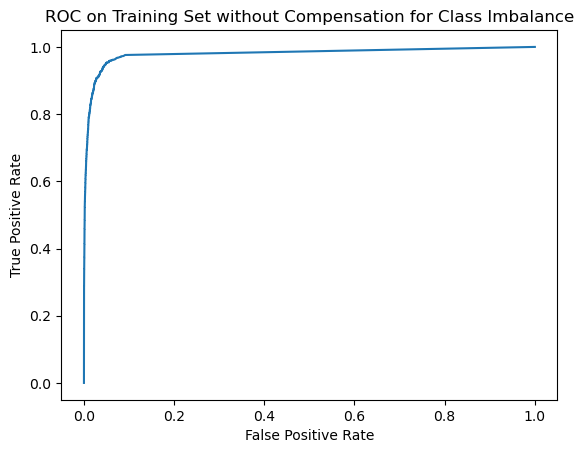

In [17]:
# ROC of training set
y_train_pred_proba = clf.predict_proba(X_train)[:, 1]
fpr, tpr, threshold = roc_curve(y_train, y_train_pred_proba)

plt.plot(fpr,tpr)
plt.title('ROC on Training Set without Compensation for Class Imbalance')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [18]:
# AUC of training set
auc_val_train = roc_auc_score(y_train, y_train_pred_proba)
print('AUC:', auc_val_train)

AUC: 0.9797063389830508


In [19]:
# Misclassification rate of training set
misclassification_rate_train = 1 - accuracy_score(y_train, y_train_pred)
print('misclassification rate:', misclassification_rate_train)

misclassification rate: 0.01151666666666662


In [20]:
# Test the classifier
y_pred = clf.predict(X_test)

In [21]:
# Confusion matrix of test set
print('confusion matrix:')
print(confusion_matrix(y_test, y_pred))

confusion matrix:
[[15616     9]
 [  247   128]]


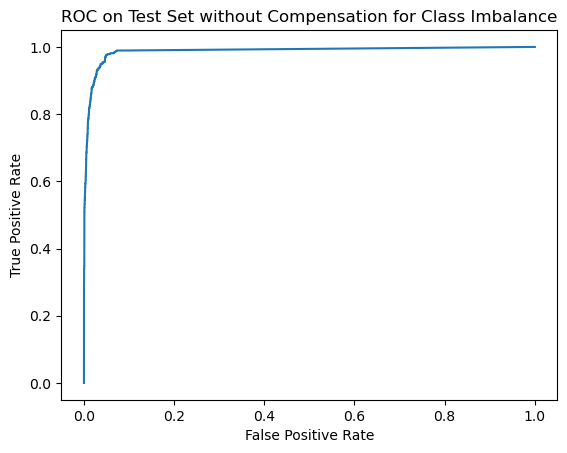

In [22]:
# ROC of test set
y_pred_proba = clf.predict_proba(X_test)[:, 1]
fpr, tpr, threshold = roc_curve(y_test, y_pred_proba)

plt.plot(fpr,tpr)
plt.title('ROC on Test Set without Compensation for Class Imbalance')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [23]:
# AUC of test set
auc_val_test = roc_auc_score(y_test, y_pred_proba)
print('AUC:', auc_val_test)

AUC: 0.9874448213333332


In [24]:
# Misclassification rate of test set
misclassification_rate_test = 1 - accuracy_score(y_test, y_pred)
print('misclassification rate:', misclassification_rate_test)

misclassification rate: 0.016000000000000014


In [25]:
# Out of Bag error estimate
oob_error = 1 - clf.oob_score_
print('Out of Bag error estimate:', oob_error)

Out of Bag error estimate: 0.011833333333333362


The Out of Bag error estimate is slightly smaller than the misclassification rate of the test set.

## 1. (d) Compensate for class imbalance and repeat 1. (c)

In [26]:
# Train a random forest classifier
clf_balanced = RandomForestClassifier(max_depth = 3, oob_score = True, class_weight = 'balanced', random_state = 42)
clf_balanced = clf_balanced.fit(X_train, y_train)

In [27]:
# Confusion matrix of training set
y_train_pred = clf_balanced.predict(X_train)
print('confusion matrix:')
print(confusion_matrix(y_train, y_train_pred))

confusion matrix:
[[55727  3273]
 [   39   961]]


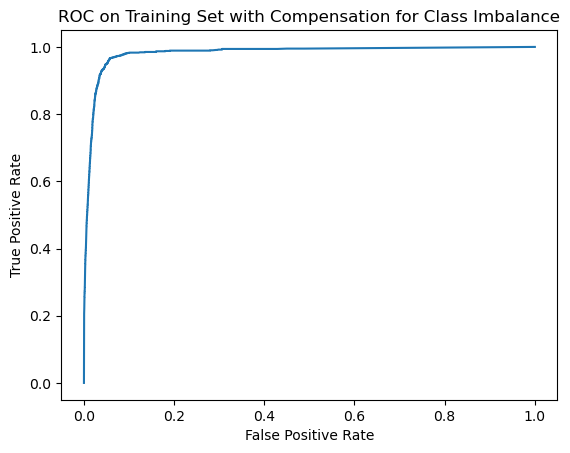

In [28]:
# ROC of training set
y_train_pred_proba = clf_balanced.predict_proba(X_train)[:, 1]
fpr, tpr, threshold = roc_curve(y_train, y_train_pred_proba)

plt.plot(fpr,tpr)
plt.title('ROC on Training Set with Compensation for Class Imbalance')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [29]:
# AUC of training set
auc_val_train_balanced = roc_auc_score(y_train, y_train_pred_proba)
print('AUC:', auc_val_train_balanced)

AUC: 0.9817033135593222


In [30]:
# Misclassification rate of training set
misclassification_rate_train_balanced = 1 - accuracy_score(y_train, y_train_pred)
print('misclassification rate:', misclassification_rate_train_balanced)

misclassification rate: 0.05520000000000003


In [31]:
# Test the classifier
y_pred = clf_balanced.predict(X_test)

In [32]:
# Confusion matrix of test set
print('confusion matrix:')
print(confusion_matrix(y_test, y_pred))

confusion matrix:
[[14791   834]
 [   10   365]]


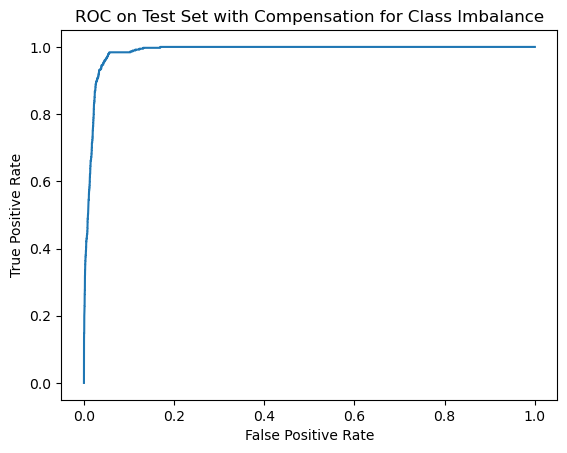

In [33]:
# ROC of test set
y_pred_proba = clf_balanced.predict_proba(X_test)[:, 1]
fpr, tpr, threshold = roc_curve(y_test, y_pred_proba)

plt.plot(fpr,tpr)
plt.title('ROC on Test Set with Compensation for Class Imbalance')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [34]:
# AUC of test set
auc_val_test_balanced = roc_auc_score(y_test, y_pred_proba)
print('AUC:', auc_val_test_balanced)

AUC: 0.986450176


In [35]:
# Misclassification rate of test set
misclassification_rate_test_balanced = 1 - accuracy_score(y_test, y_pred)
print('misclassification rate:', misclassification_rate_test_balanced)

misclassification rate: 0.052749999999999964


In [36]:
# Out of Bag error
oob_error_balanced = 1 - clf_balanced.oob_score_
print('Out of Bag error:', oob_error_balanced)

Out of Bag error: 0.055433333333333334


Training sets:

- confusion matrix false positives: 36 for imbalanced, 3273 for balanced

- confusion matrix false negatives: 655 for imbalanced, 39 for balanced

- AUC: 0.9797063389830508 for imbalanced, 0.9817033135593222 for balanced

- misclassification rate: 0.01151666666666662 for imbalanced, 0.05520000000000003 for balanced

Test sets:

- confusion matrix false positives: 9 for imbalanced, 834 for balanced

- confusion matrix false negatives: 247 for imbalanced, 10 for balanced

- AUC: 0.9874448213333332 for imbalanced, 0.986450176 for balanced

- misclassification rate: 0.016000000000000014 for imbalanced, 0.052749999999999964 for balanced

Out of Bag error:

- 0.011833333333333362 for imbalanced, 0.055433333333333334 for balanced

After balancing the data, there are more false positives but less false negatives, and the misclassification rate and the Out of Bag error slightly increased.

## 1. (e) XGBoost and Model Trees

In [37]:
# Cross validate for best alpha
alphas = np.linspace(0.01, 0.1, 10)
param = {'reg_alpha': alphas}
xgb = XGBClassifier(objective = 'reg:logistic', random_state = 42)

clf = GridSearchCV(estimator = xgb, param_grid = param, cv = StratifiedKFold(5))
clf = clf.fit(X_train, y_train)

In [38]:
# Choose the best alpha
best_alpha = clf.best_params_['reg_alpha']
print('alpha chosen by cross-validation:', best_alpha)

alpha chosen by cross-validation: 0.09000000000000001


In [39]:
# Use the best alpha to refit the model
xgb = XGBClassifier(objective = 'reg:logistic', reg_alpha = best_alpha, random_state = 42)

In [40]:
# Use 5 fold cross validation methods to estimate the error
cv_score = cross_val_score(estimator = xgb, X = X_train, y = y_train, cv = StratifiedKFold(5)).mean()
error = 1 - cv_score
print('error from 5 fold cross validation:', error)

error from 5 fold cross validation: 0.005266666666666753


In [41]:
# Test error
xgb = xgb.fit(X_train, y_train)
y_pred = xgb.predict(X_test)
test_error = mean_squared_error(y_test, y_pred)
print('test error:', test_error)

test error: 0.0060625


The error obtained from 5 fold cross validation is 0.005266666666666753, and the test error is 0.0060625, which is slightly higher.

In [42]:
# Confusion matrix of training set
y_train_pred = xgb.predict(X_train)
print('confusion matrix:')
print(confusion_matrix(y_train, y_train_pred))

confusion matrix:
[[59000     0]
 [    1   999]]


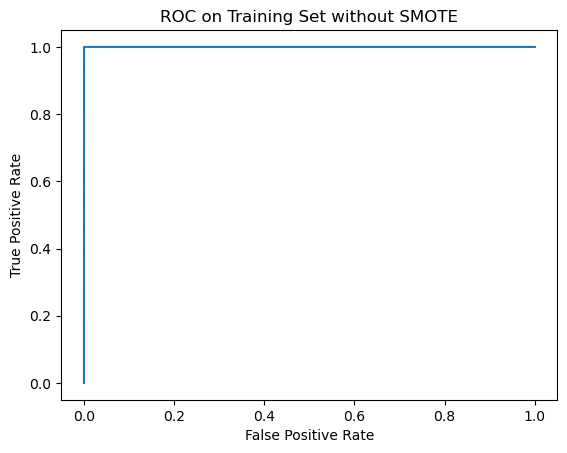

In [43]:
# ROC of training set
y_train_pred_proba = xgb.predict_proba(X_train)[:, 1]
fpr, tpr, threshold = roc_curve(y_train, y_train_pred_proba)

plt.plot(fpr,tpr)
plt.title('ROC on Training Set without SMOTE')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [44]:
# AUC of training set
auc_val_train = roc_auc_score(y_train, y_train_pred_proba)
print('AUC:', auc_val_train)

AUC: 0.9999997627118644


In [45]:
# Confusion matrix of test set
print('confusion matrix:')
print(confusion_matrix(y_test, y_pred))

confusion matrix:
[[15611    14]
 [   83   292]]


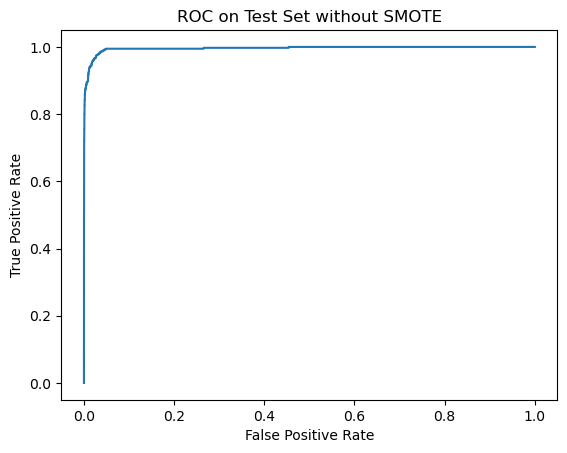

In [46]:
# ROC of test set
y_pred_proba = xgb.predict_proba(X_test)[:, 1]
fpr, tpr, threshold = roc_curve(y_test, y_pred_proba)

plt.plot(fpr,tpr)
plt.title('ROC on Test Set without SMOTE')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [47]:
# AUC of test set
auc_val_test = roc_auc_score(y_test, y_pred_proba)
print('AUC:', auc_val_test)

AUC: 0.9957864106666666


## 1. (f) Use SMOTE to pre-process data and repeat 1. (e)

In [48]:
# Cross validate for best alpha
smote = SMOTE(random_state = 42)
xgb = XGBClassifier(objective = 'reg:logistic', random_state = 42)
param = {'classifier__reg_alpha': alphas}

pipeline = Pipeline(steps = [['smote', smote], ['classifier', xgb]])

clf = GridSearchCV(estimator = pipeline, param_grid = param, cv = StratifiedKFold(5))
clf = clf.fit(X_train, y_train)

In [49]:
# Choose the best alpha
best_alpha = clf.best_params_['classifier__reg_alpha']
print('alpha chosen by cross-validation:', best_alpha)

alpha chosen by cross-validation: 0.1


In [50]:
# Use the best alpha to refit the model
xgb = XGBClassifier(objective = 'reg:logistic', reg_alpha = best_alpha, random_state = 42)

In [51]:
# Use 5 fold cross validation methods to estimate the error
X_train, y_train = smote.fit_resample(X_train, y_train)
cv_score = cross_val_score(estimator = xgb, X = X_train, y = y_train, cv = StratifiedKFold(5)).mean()
error = 1 - cv_score
print('error from 5 fold cross validation:', error)

error from 5 fold cross validation: 0.0027033898305084403


In [52]:
# Test error
xgb = xgb.fit(X_train, y_train)
y_pred = xgb.predict(X_test)
test_error = mean_squared_error(y_test, y_pred)
print('test error:', test_error)

test error: 0.0075625


The error obtained from 5 fold cross validation is 0.0027033898305084403, and the test error is 0.0075625, which is slightly higher.

In [53]:
# Confusion matrix of training set
y_train_pred = xgb.predict(X_train)
print('confusion matrix:')
print(confusion_matrix(y_train, y_train_pred))

confusion matrix:
[[59000     0]
 [    2 58998]]


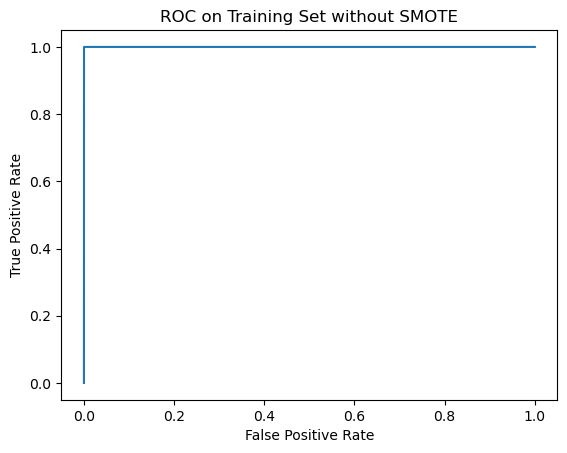

In [54]:
# ROC of training set
y_train_pred_proba = xgb.predict_proba(X_train)[:, 1]
fpr, tpr, threshold = roc_curve(y_train, y_train_pred_proba)

plt.plot(fpr,tpr)
plt.title('ROC on Training Set without SMOTE')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [55]:
# AUC of training set
auc_val_train_balanced = roc_auc_score(y_train, y_train_pred_proba)
print('AUC:', auc_val_train_balanced)

AUC: 0.9999999968399885


In [56]:
# Confusion matrix of test set
print('confusion matrix:')
print(confusion_matrix(y_test, y_pred))

confusion matrix:
[[15577    48]
 [   73   302]]


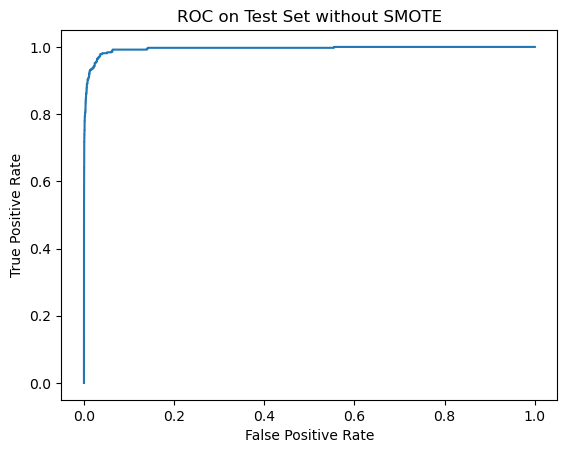

In [57]:
# ROC of test set
y_pred_proba = xgb.predict_proba(X_test)[:, 1]
fpr, tpr, threshold = roc_curve(y_test, y_pred_proba)

plt.plot(fpr,tpr)
plt.title('ROC on Test Set without SMOTE')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [58]:
# AUC of test set
auc_val_test_balanced = roc_auc_score(y_test, y_pred_proba)
print('AUC:', auc_val_test_balanced)

AUC: 0.9946924373333333


Training sets:

- confusion matrix false positives: 0 for imbalanced, 0 for balanced

- confusion matrix false negatives: 1 for imbalanced, 2 for balanced

- AUC: 0.9999997627118644 for imbalanced, 0.9999999968399885 for balanced

Test sets:

- confusion matrix false positives: 14 for imbalanced, 48 for balanced

- confusion matrix false negatives: 83 for imbalanced, 73 for balanced

- AUC: 0.9957864106666666 for imbalanced, 0.9946924373333333 for balanced

- misclassification rate: 0.0060625 for imbalanced, 0.0075625 for balanced

Error from 5 fold cross validation:

- 0.005266666666666753 for imbalanced, 0.0027033898305084403 for balanced

After balancing the data, the training sets have very similar results. The test sets showed more false positives and less false negatives. The AUC score is slightly lower, and the test error is slightly higher. The error from 5 fold cross validation decreased.

# 2. ISLR 6.6.3

## 2. (a) Training RSS

As we increase $s$ from 0, the training RSS will steadily decrease because larger $s$ can allow more freedom and less penalty on $\beta$. Then, the value of $\beta$ can become close to the real value.

## 2. (b) Test RSS

As we increase $s$ from 0, test RSS will decrease initially and then eventually start increasing in a U shape. At the beginning, the test RSS decreases under the same reason for the training RSS. However, when $s$ gets larger, there will be overfitting on the data, and it will lead to an increase in the test RSS.

## 2. (c) Variance

As we increase $s$ from 0, variance will steadily increase because increasing the flexibility will cause the variance to increase

## 2. (d) Squared bias

As we increase $s$ from 0, squared bias will steadily decrease because increasing the flexibility will cause the bias to decrease.

## 2. (e) Irreducible error

As we increase $s$ from 0, irreducible error will remain constant because it is irreducible. It will not be affected by parameters, regularization, etc.

# 3. ISLR 6.6.5

## 3. (a) Ridge regression optimization problem

Minimize $\beta$:
\begin{align}
& \sum^{n}_{i = 1} (y_{i} - \beta_{0} - \sum^{p}_{j = 1} \beta_{j}x_{ij})^{2} + \lambda \sum^{p}_{j = 1} \beta^{2}_{j} \\
=& \sum^{2}_{i = 1} (y_{i} - \beta_{0} - \sum^{2}_{j = 1} \beta_{j}x_{ij})^{2} + \lambda \sum^{2}_{j = 1} \beta^{2}_{j} \\
=& (y_{1} - \beta_{1}x_{11} - \beta_{2}x_{12})^{2} + (y_{2} - \beta_{1}x_{21} - \beta_{2}x_{22})^{2} + \lambda (\beta^{2}_{1} + \beta^{2}_{2})
\end{align}

## 3. (b) Argue that $\hat{\beta}_{1} = \hat{\beta}_{2}$

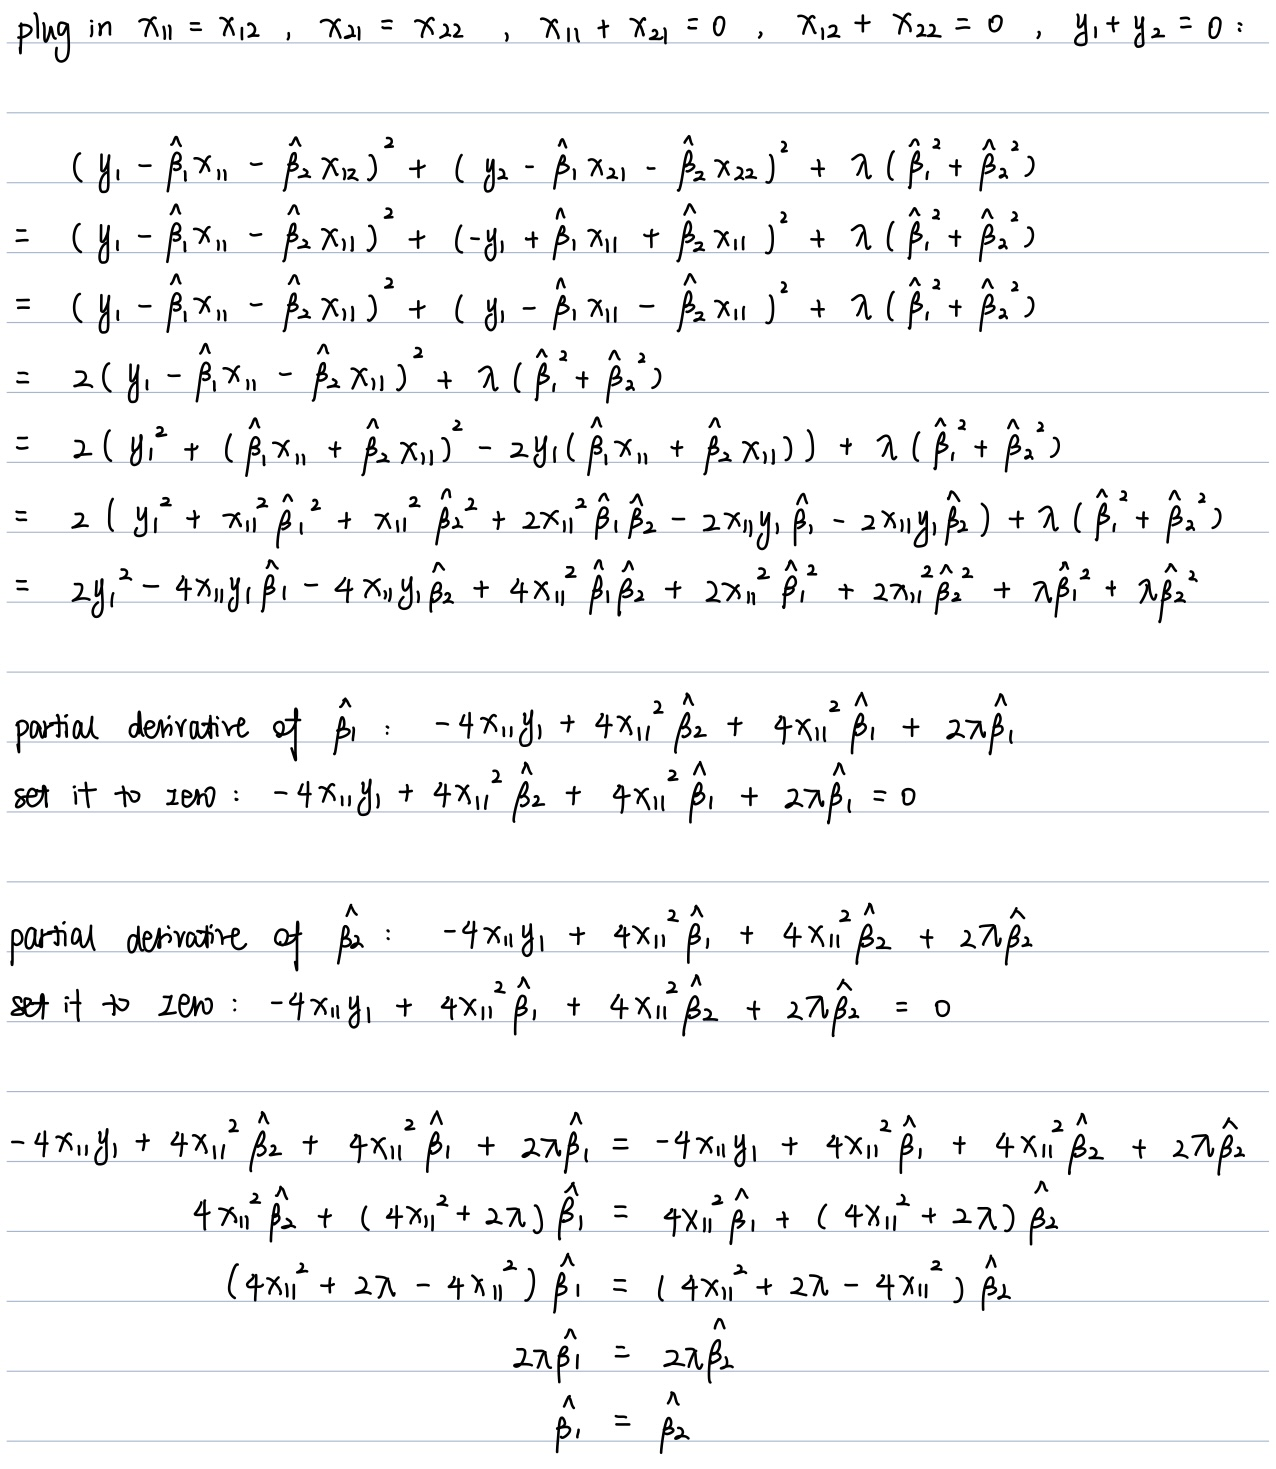

## 3. (c) Lasso optimization problem

Minimize $\beta$:
\begin{align}
& \sum^{n}_{i = 1} (y_{i} - \beta_{0} - \sum^{p}_{j = 1} \beta_{j}x_{ij})^{2} + \lambda \sum^{p}_{j = 1} |\beta_{j}| \\
=& \sum^{2}_{i = 1} (y_{i} - \beta_{0} - \sum^{2}_{j = 1} \beta_{j}x_{ij})^{2} + \lambda \sum^{2}_{j = 1} |\beta_{j}| \\
=& (y_{1} - \beta_{1}x_{11} - \beta_{2}x_{12})^{2} + (y_{2} - \beta_{1}x_{21} - \beta_{2}x_{22})^{2} + \lambda (|\beta_{1}| + |\beta_{2}|)
\end{align}

## 3. (d) Argue that $\hat{\beta}_{1}$ and $\hat{\beta}_{2}$ are not unique

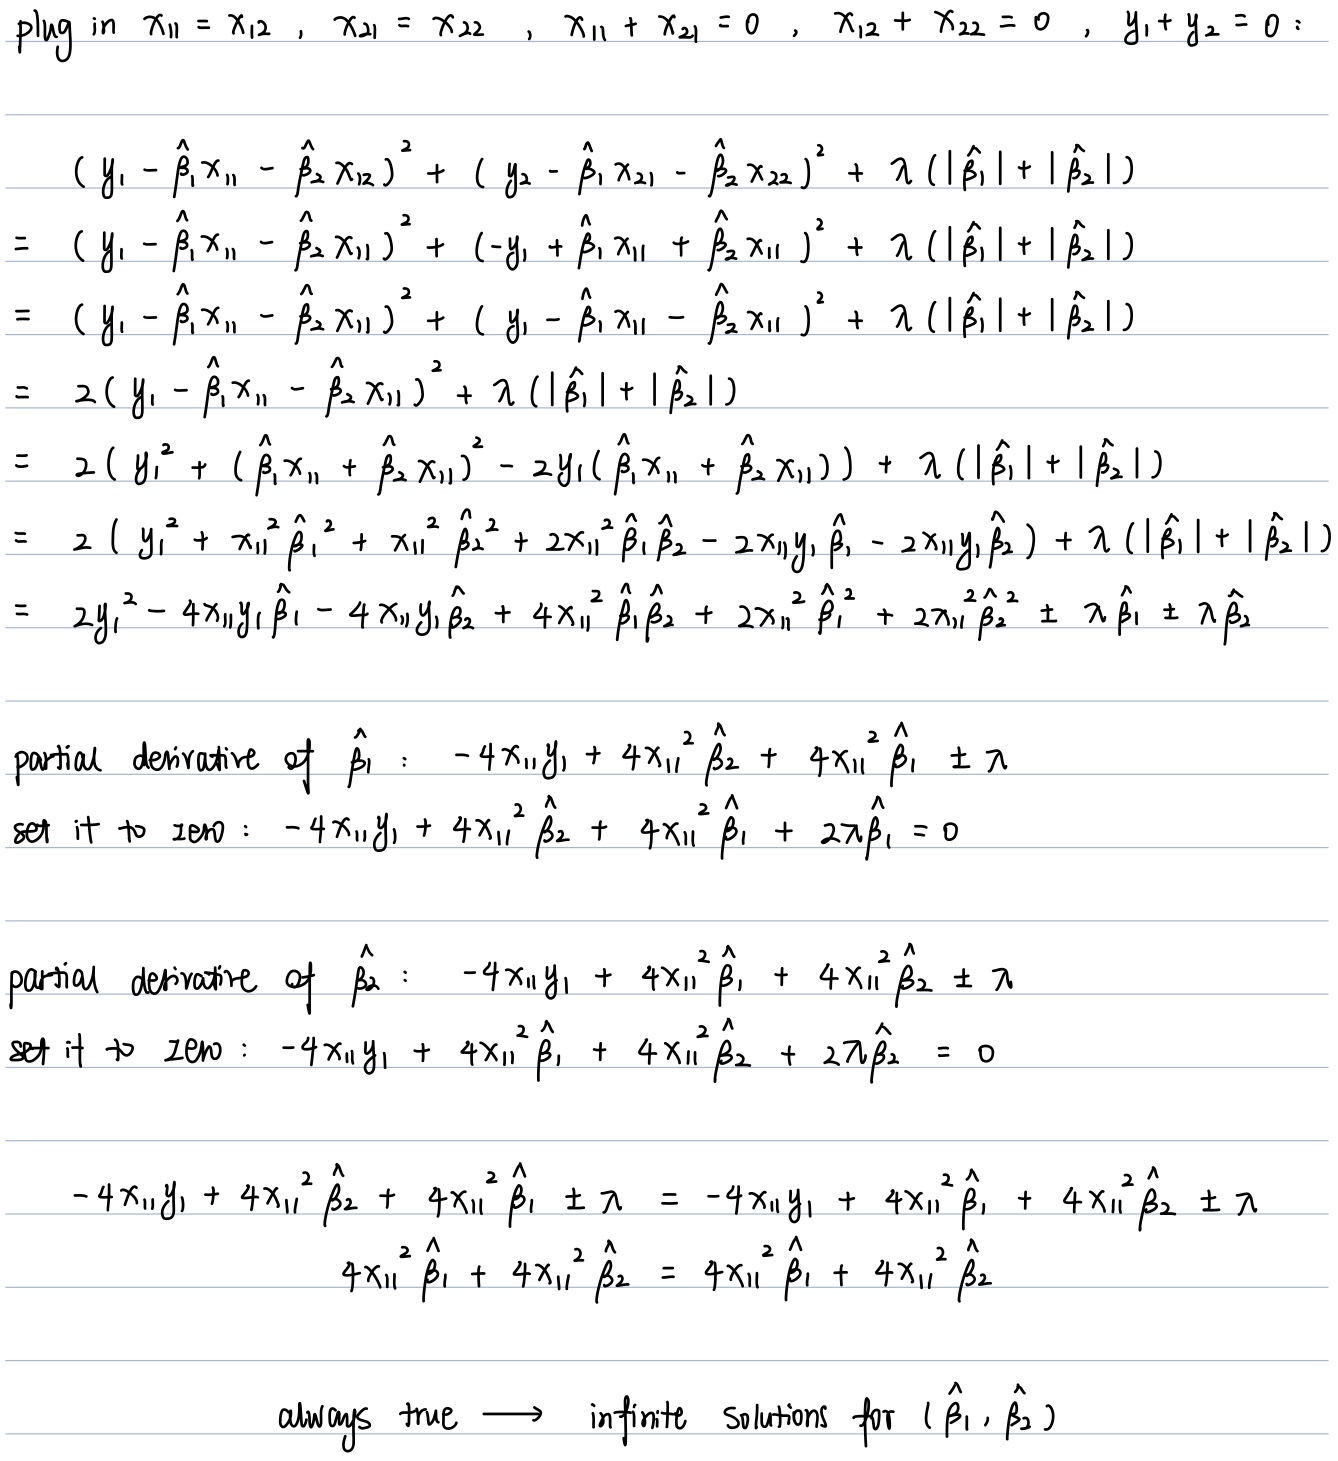

# 4. ISLR 8.4.5

Majority vote approach:

In 0.1, 0.15, 0.2, 0.2, 0.55, 0.6, 0.6, 0.65, 0.7, and 0.75, 6 out of 10 estimates are greater than 0.5, so the majority vote approach says the class is red.

Average probability approach:

Since the average estimate is $(0.1 + 0.15 + 0.2 + 0.2 + 0.55 + 0.6 + 0.6 + 0.65 + 0.7 + 0.75) / 10 = 0.45$, which is smaller than 0.5, so the average probability approach says the class is not red but green.

# 5. ISLR 9.7.3

## 5. (a) Sketch the observations

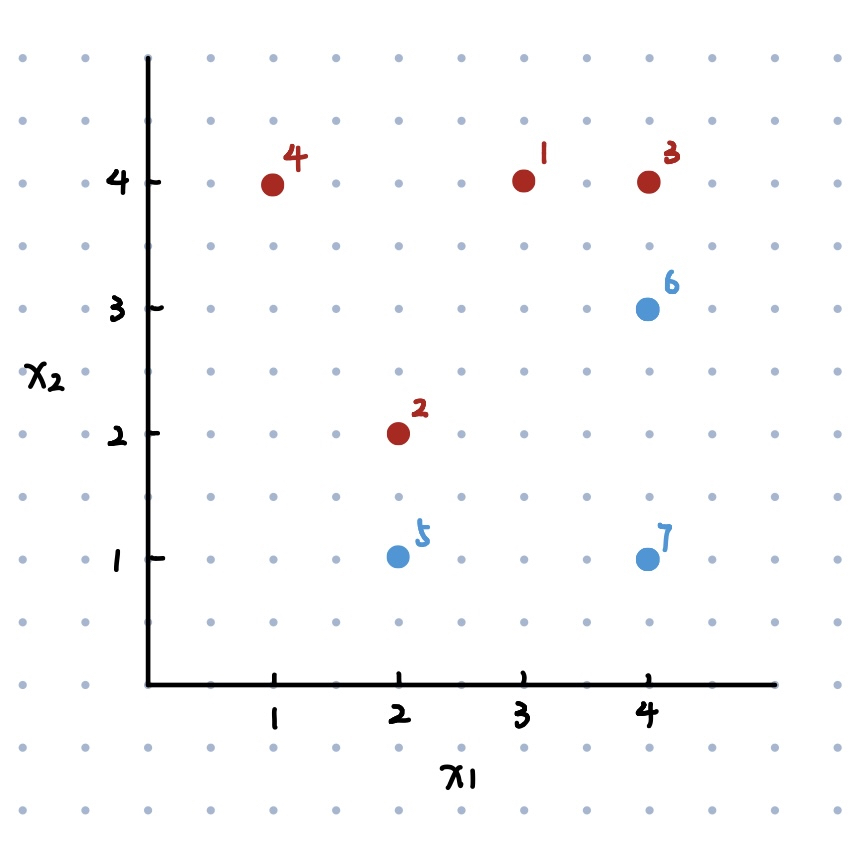

## 5. (b) Sketch the optimal separating hyperplane and provide the equation for this hyperplane

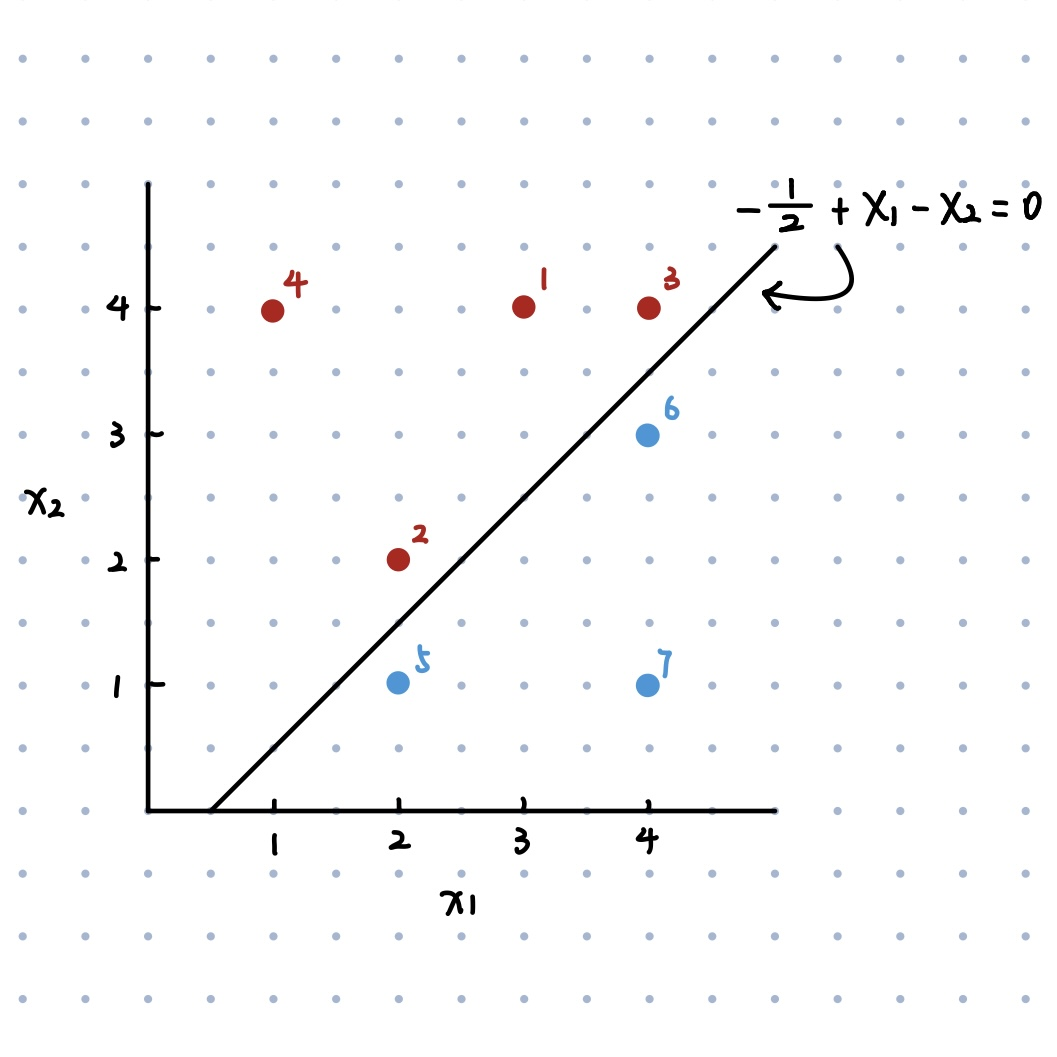
Hyperplane: $-\frac{1}{2} + X_{1} - X_{2} = 0$

## 5. (c) Describe the classification rule for the maximal margin classifier

$\beta_{0} = - \frac{1}{2}$, $\beta_{1} = 1$, $\beta_{2} = -1$

Classify to Red if $-\frac{1}{2} + X_{1} - X_{2} < 0$, and classify to Blue otherwise.

## 5. (d)  Indicate the margin for the maximal margin hyperplane

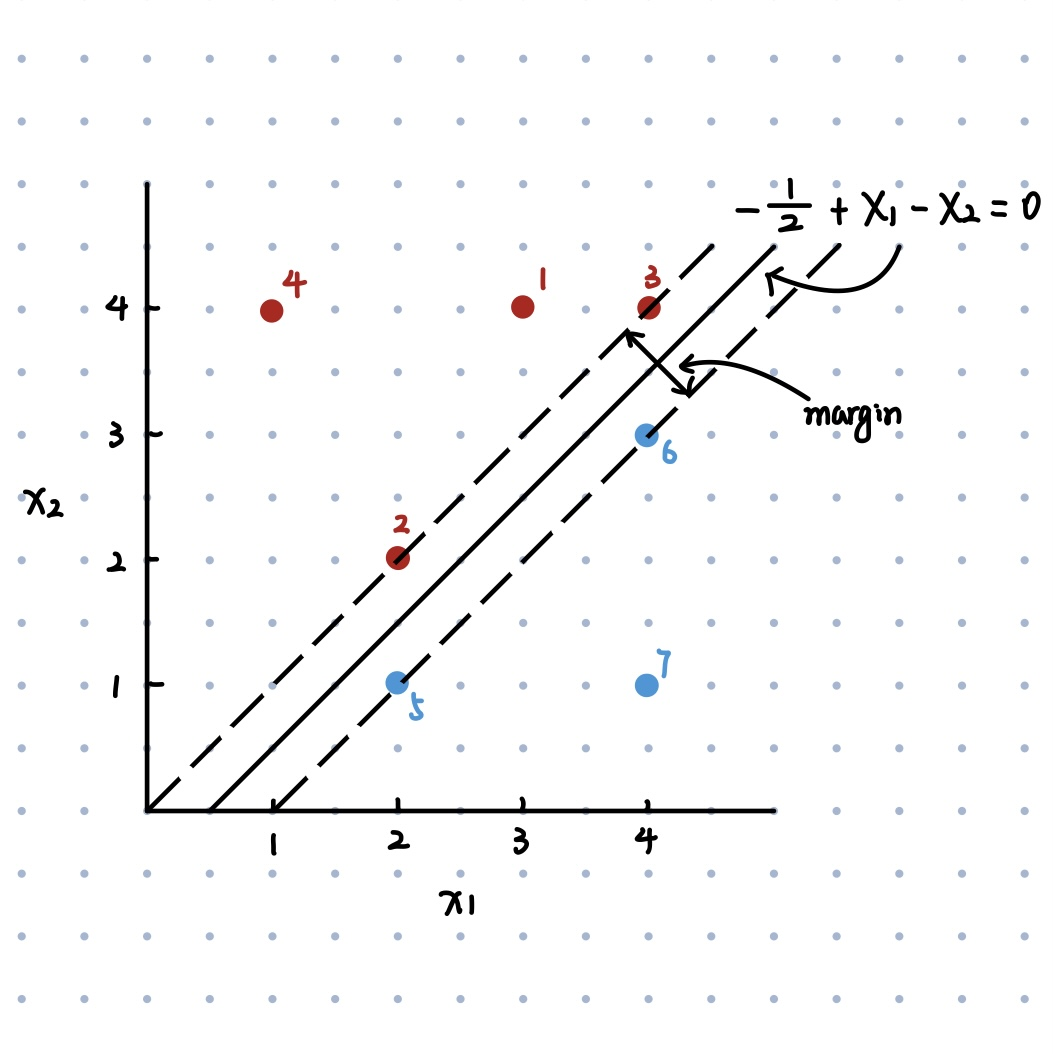

## 5. (e) Indicate the support vectors for the maximal margin classifier

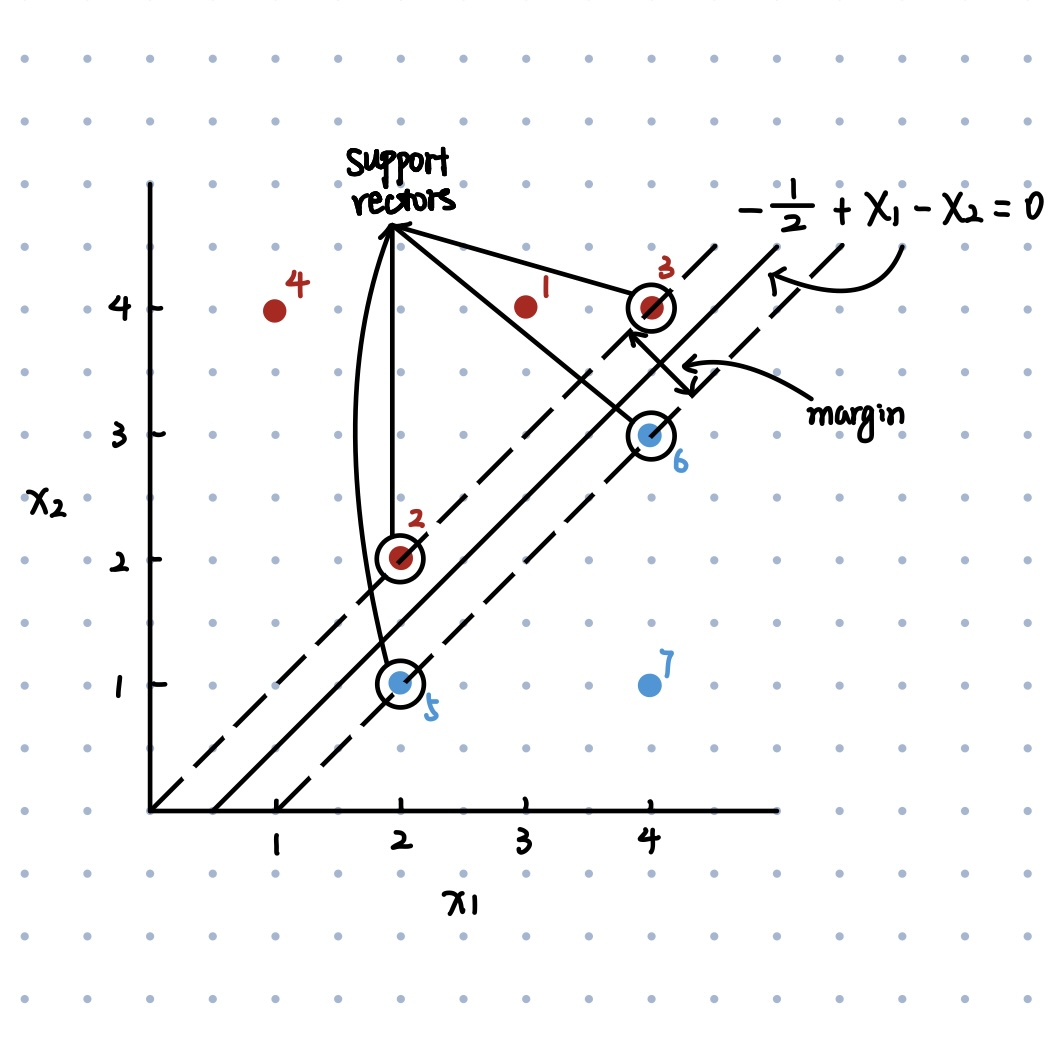

Support vectors: observations 2, 3, 5, 6

## 5. (f) Argue that a slight movement of the seventh observation would not affect the maximal margin hyperplane

Since observation 7 is not a support vector, moving it would not affect the location of the hyperplane.

## 5. (g) Sketch a hyperplane that is not the optimal separating hyperplane and provide the equation for this hyperplane

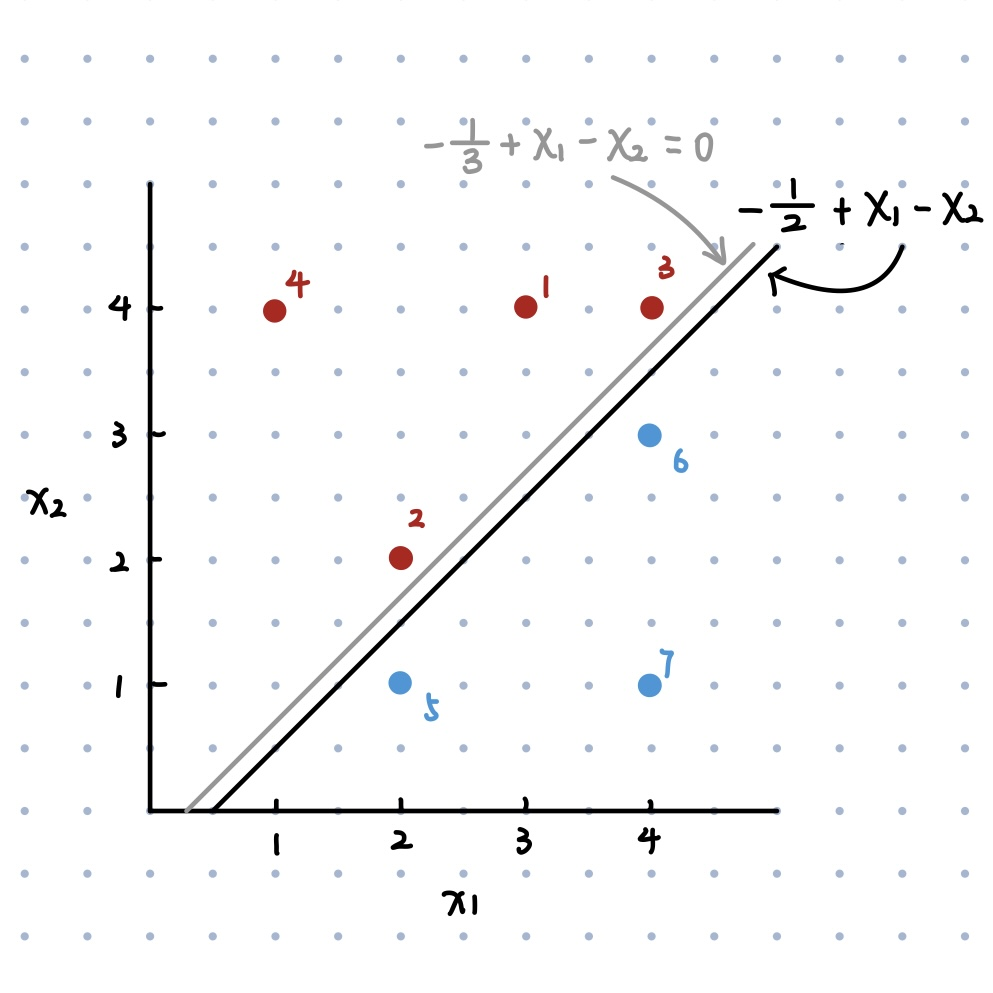

Hyperplane: $-\frac{1}{3} + X_{1} - X_{2} = 0$

## 5. (h) Draw an additional observation on the plot so that the two classes are no longer separable by a hyperplane

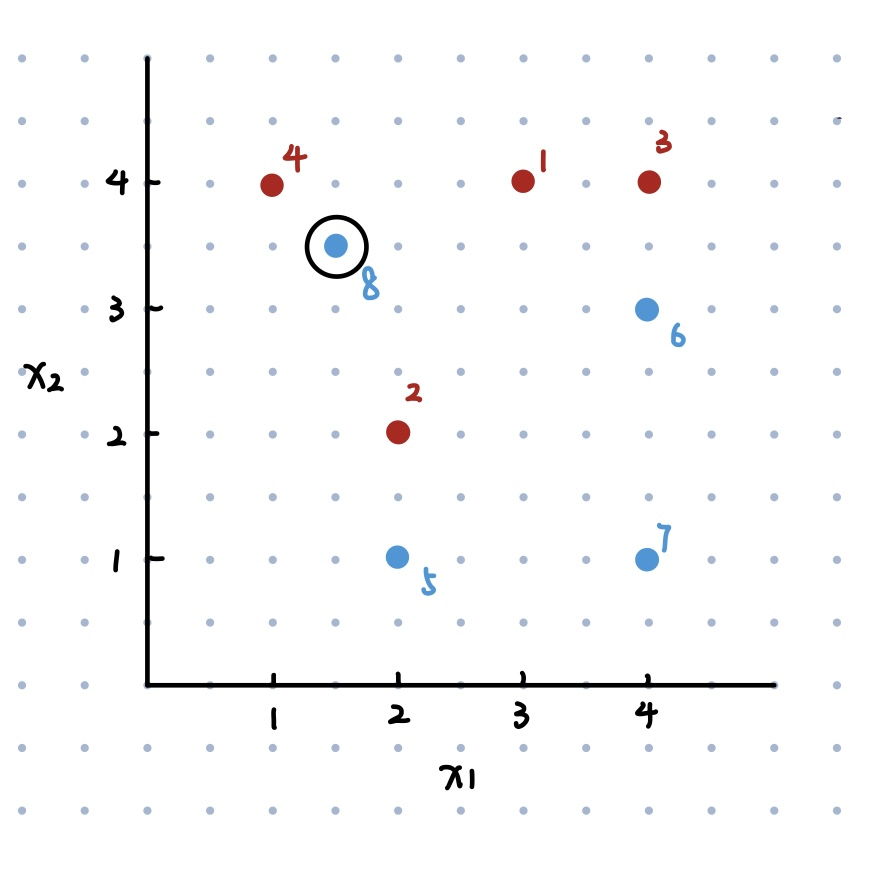

Observation 8 can make the two classes no longer separable by a hyperplane.